Model R2 Score: 0.9675911750696472
Model RMSE: 196.7920502118707
Model Accuracy (%): 96.75911750696471


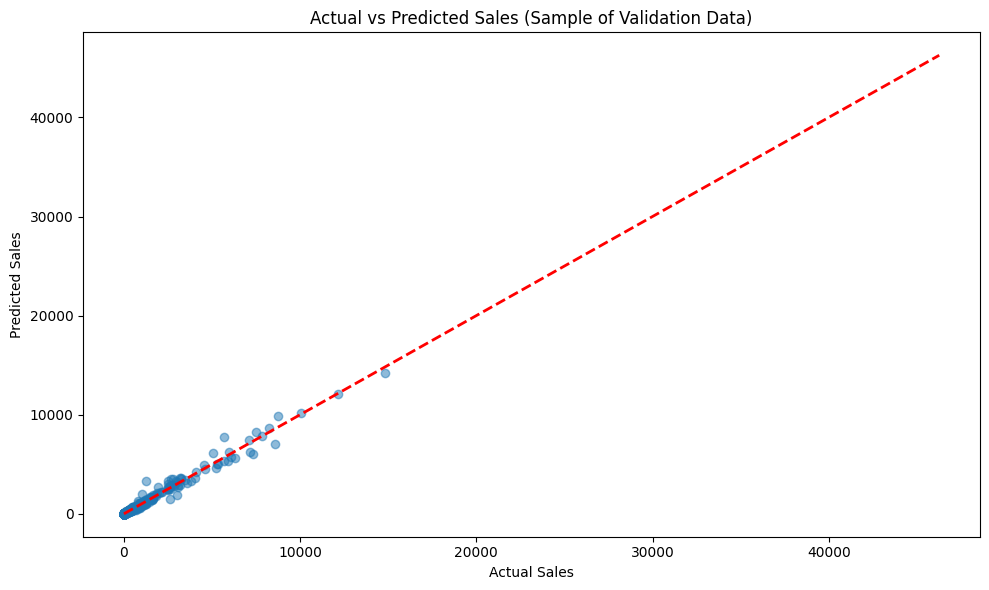

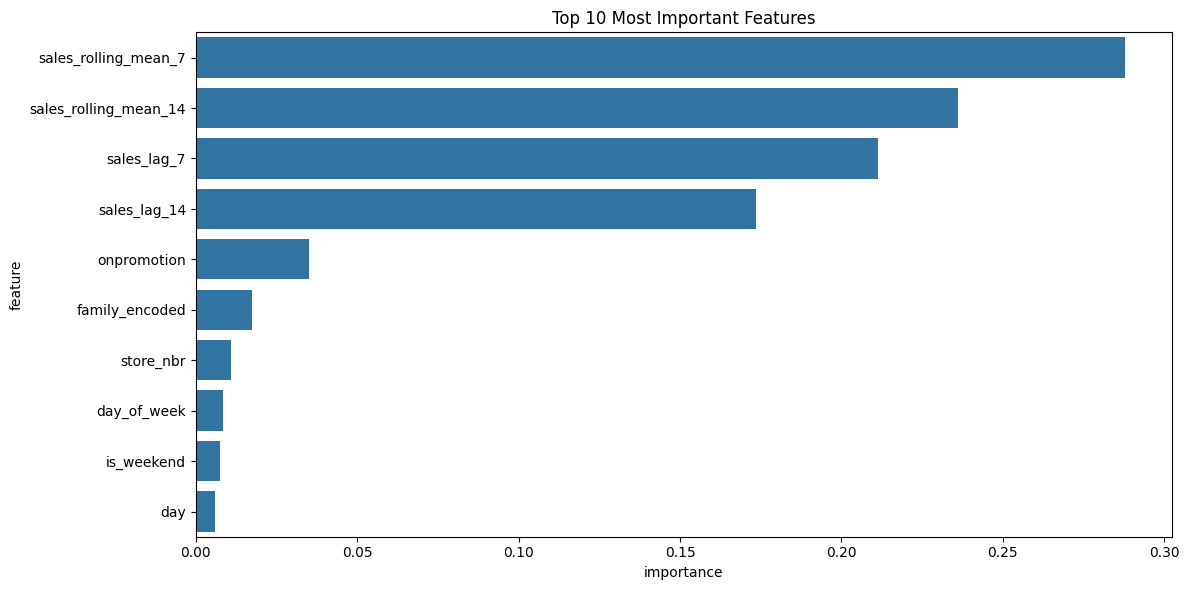

Predictions saved to random_forest_predictions.csv


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Convert date column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Create date features
def create_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['quarter'] = df['date'].dt.quarter
    return df

train_df = create_date_features(train_df)
test_df = create_date_features(test_df)

# Create lag features for sales (only for training data)
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)
train_df['sales_lag_14'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(14)
train_df['sales_rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
train_df['sales_rolling_mean_14'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# Label encode categorical variables
le = LabelEncoder()
train_df['family_encoded'] = le.fit_transform(train_df['family'])
test_df['family_encoded'] = le.transform(test_df['family'])

# Select features for model
feature_columns = ['store_nbr', 'family_encoded', 'onpromotion', 
                  'year', 'month', 'day', 'day_of_week', 'is_weekend',
                  'is_month_start', 'is_month_end', 'quarter']

# Add lag features to feature columns
lag_features = ['sales_lag_7', 'sales_lag_14', 'sales_rolling_mean_7', 'sales_rolling_mean_14']
feature_columns.extend(lag_features)

# Drop rows with NaN values (caused by lag features)
train_df = train_df.dropna()

# Prepare features and target
X = train_df[feature_columns]
y = train_df['sales']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and train Random Forest model with optimized parameters
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Make predictions on validation set
val_predictions = rf_model.predict(X_val_scaled)

# Calculate R2 score and RMSE
r2 = r2_score(y_val, val_predictions)
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

print('Model R2 Score:', r2)
print('Model RMSE:', rmse)
print('Model Accuracy (%):', r2 * 100)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val[:1000], val_predictions[:1000], alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Sample of Validation Data)')
plt.tight_layout()
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

# Prepare test data
# Fill missing lag features with median values from training data
for lag_feature in lag_features:
    test_df[lag_feature] = train_df[lag_feature].median()

X_test = test_df[feature_columns]
X_test_scaled = scaler.transform(X_test)

# Make predictions on test data
test_predictions = rf_model.predict(X_test_scaled)

# Add predictions to test dataframe and save to CSV
test_df['predicted_sales'] = test_predictions
predictions_df = test_df[['id', 'date', 'store_nbr', 'family', 'predicted_sales']]
predictions_df.to_csv('random_forest_predictions.csv', index=False)

print('Predictions saved to random_forest_predictions.csv')